# Spotify Music Library Exploration
The goal of this project was to learn working with SQL while finding some interesting insights about my Spotify music library (in this case, all my saved albums and corresponding artists).

First, we need to connect to the database to get the access to the data we want to analyze:

In [ ]:
import duckdb
con = duckdb.connect("database.db", read_only=True)

## Looking at albums and artists:

Let us take a look on the structure of the database. We have two tables containing our albums and artists with the corresponding spotify ids and other interesting data. The following two cells show the contents of these tables.

In [ ]:
# show artists database
con.sql("SELECT * FROM artists").df()

In [ ]:
# show albums database
con.sql("SELECT * FROM albums").df()

The albums and artist have a many-to-many relationship between each other. Artist can publish many albums and album can be recorded by multiple artists. Each of the album-artist connections is present in the album_artist table, which can be used to connect the artist and albums table to reveal some more interesting information. The following cell shows how to list the artists in an alphabetical order together with the list of their albums.

In [ ]:
# show list of artists in alphabetical order and the list of their albums
con.sql("""
        SELECT artists.name AS Artist, LIST(albums.name) as Albums
        FROM artists INNER JOIN album_artist ON artists.spotify_id=album_artist.artist_id INNER JOIN albums ON album_artist.album_id=albums.spotify_id
        GROUP BY artists.name
        ORDER BY artists.name ASC
    """).df()

We can also see the album counts and sort the artists based on that. That way we can see which artists are the favorites based on the albums saved.

In [265]:
# find which artists have the most saved albums
con.sql("""
        SELECT artists.name AS artist, COUNT(albums.name) as number_of_albums_saved
        FROM albums 
        JOIN album_artist ON albums.spotify_id = album_artist.album_id
        JOIN artists ON artists.spotify_id = album_artist.artist_id  
        GROUP BY artist
        ORDER BY number_of_albums_saved DESC LIMIT 15
    """).df()

,artist,number_of_albums_saved
0,Zrní,11
1,King Gizzard & The Lizard Wizard,10
2,System Of A Down,8
3,Slipknot,6
4,Radiohead,5
5,Sufjan Stevens,4
6,P. Rosa,4
7,corn wave,4
8,Madhouse Express,4
9,TOBACCO,4


One can use this functionality to find all the albums from a given artist (next cell) or even all other albums by the artist of a given album (the cell after that).

In [266]:
# find all albums by the given artist
given_artist = "Sufjan Stevens"
con.execute("""
        SELECT DISTINCT artists.name AS artist_name, albums.name AS album_name  
        FROM albums 
        LEFT JOIN album_artist ON albums.spotify_id=album_artist.album_id
        JOIN artists ON album_artist.artist_id=artists.spotify_id
        WHERE artist_name = ?
        """, (given_artist,)).df()

,artist_name,album_name
0,Sufjan Stevens,Illinois
1,Sufjan Stevens,Carrie & Lowell
2,Sufjan Stevens,Javelin
3,Sufjan Stevens,Carrie & Lowell (10th Anniversary Edition)


In [267]:
# find artist based on an album and then other albums by that artist
analyzed_album = "softscars"
artist_id = con.execute("""        
        SELECT DISTINCT artists.spotify_id AS artist_id, artists.name AS artist_name, albums.name AS album_name  
        FROM albums 
        LEFT JOIN album_artist ON albums.spotify_id=album_artist.album_id
        JOIN artists ON album_artist.artist_id=artists.spotify_id
        WHERE album_name=?;
        """,(analyzed_album,)).df()["artist_id"][0]
con.execute("""
        SELECT DISTINCT artists.name AS artist_name, albums.name AS album_name  
        FROM albums 
        LEFT JOIN album_artist ON albums.spotify_id=album_artist.album_id
        JOIN artists ON album_artist.artist_id=artists.spotify_id
        WHERE artists.spotify_id=? AND albums.name!=?;
        """,(artist_id, analyzed_album,)).df()

,artist_name,album_name
0,yeule,Glitch Princess
1,yeule,Serotonin II
2,yeule,Evangelic Girl is a Gun


We can even use this database to be a bit nostalgic and give us tips on what to listen to. The following cell will randomly pick and show us an album saved in a given year.

In [286]:
# show random album from a given year
year = 2023
con.sql(f"""
        SELECT artists.name as artist_name, albums.name as album_name, total_tracks, release_date, added_at, popularity 
        FROM albums 
        JOIN album_artist ON albums.spotify_id = album_artist.album_id
        JOIN artists ON artists.spotify_id = album_artist.artist_id 
        WHERE YEAR(added_at) = {year} 
        ORDER BY RANDOM()  
        LIMIT 1  
        """).df()

,artist_name,album_name,total_tracks,release_date,added_at,popularity
0,Casino Versus Japan,Go Hawaii,12,1999-01-01,2023-02-22 13:21:30+01:00,30


We can also take a look at the data in a form of a graph. The following plots shows how many albums were saved in a given year, given month or weekday through Spotify history.

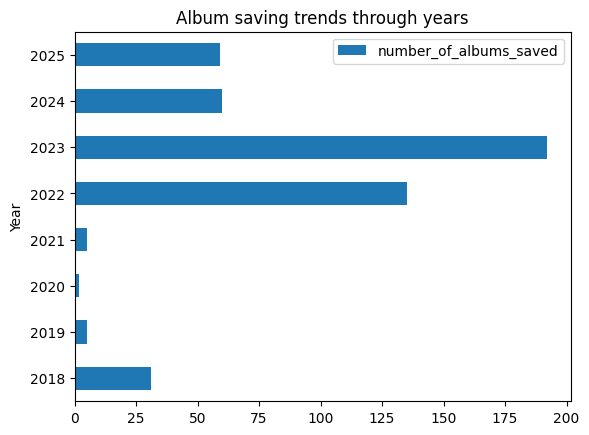

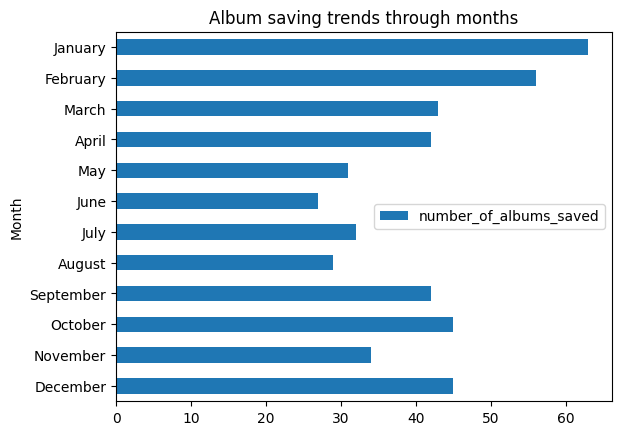

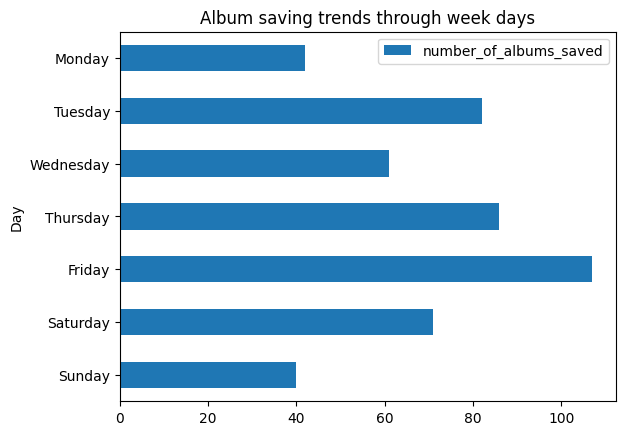

In [283]:
# Create a plot showing the number of saved in the given year or month
import matplotlib.pyplot as plt
import calendar

years = con.sql("""
        SELECT DISTINCT YEAR(added_at) as year, COUNT(albums.name) as number_of_albums_saved FROM albums
        GROUP BY year
        ORDER BY year ASC
    """).df()
months = con.sql("""
        SELECT DISTINCT MONTH(added_at) as month, COUNT(albums.name) as number_of_albums_saved FROM albums
        GROUP BY month
        ORDER BY month DESC
    """).df()
days = con.sql("""
        SELECT DISTINCT WEEKDAY(added_at) as day, COUNT(albums.name) as number_of_albums_saved FROM albums
        GROUP BY day
        ORDER BY day DESC
    """).df()
# add day names and month names to the dataframes
month_names = [calendar.month_name[m] for m in months["month"]]
months.insert(2, "month_name", month_names)
day_names = [calendar.day_name[d] for d in days["day"]]
days.insert(2, "day_name", day_names)
# show plots
years.plot(kind='barh', x='year', y='number_of_albums_saved', ylabel="Year")
title = plt.title('Album saving trends through years')
months.plot(kind='barh', x='month_name', y='number_of_albums_saved', ylabel="Month")
title = plt.title('Album saving trends through months')
days.plot(kind='barh', x='day_name', y='number_of_albums_saved', ylabel="Day")
title = plt.title('Album saving trends through week days')

We can see some interesting stuff here. For example, it seems like I really started saving albums in 2022 but really went crazy with it in 2023 with almost 200 albums saved. I have been more picky the last year and this year (2024, 2025) but there is still a considerable amount. Regarding the months, it reflects that I listed the most during January and February (most likely motivated by Spotify wrapped and LastFM stats from last year). Then my album saving gets a bit more sparse in the summer when there is a lot more stuff to do. Finally, it seems like I save the most albums on Friday, which is something I had no idea I did until now.

## Looking at genres and tags:

To make the analysis more interesting, all the genres for each of the artists pulled from spotify were saved in another table. That way, we can see what are the genre trends in our Spotify library. For example, the next cell shows the top 10 genres with a list of corresponding artists.

In [287]:
# show 10 most frequent genres
con.sql("""
        SELECT genre, COUNT(name) AS count, LIST(name) AS artists 
        FROM artists INNER JOIN artist_genre ON artists.spotify_id=artist_genre.artist_id 
        GROUP BY genre ORDER BY count DESC LIMIT 10
    """).df()

,genre,count,artists
0,post-rock,44,"[These New Puritans, Deafheaven, Sigur Rós, mú..."
1,slowcore,37,"[SPIRIT OF THE BEEHIVE, They Are Gutting a Bod..."
2,shoegaze,36,"[SPIRIT OF THE BEEHIVE, They Are Gutting a Bod..."
3,experimental,35,"[JPEGMAFIA, KMRU, Aho Ssan, Danny Brown, Fire-..."
4,drone,32,"[KMRU, Aho Ssan, Abul Mogard, claire rousay, S..."
5,noise rock,29,"[Squid, They Are Gutting a Body of Water, YHWH..."
6,ambient,24,"[Aphex Twin, Barker, KMRU, Boards of Canada, B..."
7,idm,22,"[Aphex Twin, múm, Barker, Aho Ssan, Boards of ..."
8,black metal,20,"[Deafheaven, Akaitsuki, Germ, Plague Organ, Ag..."
9,drone metal,19,"[Opium Eyes of Nico, Stara Rzeka, Jesu, Oranss..."


To enrich the genre data from Spotify, I integrated MusicBrainz IDs and LastFM tags. This provides community-driven categorization that often captures nuances Spotify's official genres miss (e.g., "dream pop" vs just "indie").

In [288]:
# show 10 most frequent tags
con.sql("""
        SELECT tag, SUM(weight) AS summed_weight, COUNT(name) AS count, LIST(name) AS aritists
        FROM artists INNER JOIN artist_tag ON artists.mbid=artist_tag.mbid
        GROUP BY tag ORDER BY summed_weight DESC LIMIT 10
        """).df()

,tag,summed_weight,count,aritists
0,electronic,5025.0,115,"[Magdalena Bay, Oklou, Vegyn, Loidis, Nu Genea..."
1,experimental,4690.0,146,"[Mac DeMarco, JPEGMAFIA, Vegyn, Amnesia Scanne..."
2,ambient,3848.0,89,"[Oklou, Vegyn, Have A Nice Life, Sea Power, Ap..."
3,indie,3310.0,93,"[Mac DeMarco, Geese, They Are Gutting a Body o..."
4,shoegaze,3109.0,50,"[They Are Gutting a Body of Water, Alcest, Dea..."
5,post-rock,2824.0,54,"[Squid, Alcest, Deafheaven, Have A Nice Life, ..."
6,indie rock,2556.0,67,"[Mac DeMarco, Geese, They Are Gutting a Body o..."
7,post-punk,1759.0,33,"[Mac DeMarco, Geese, Squid, These New Puritans..."
8,dream pop,1720.0,50,"[Magdalena Bay, Clairo, The xx, Sigur Rós, Eth..."
9,black metal,1571.0,25,"[Alcest, Deafheaven, Vokeebokæybgo Lochtyblchv..."


Having these, we can do all kinds of stuff like trying to find similar artists based on shared genres or tags as shown in the following two cells.

In [31]:
# based on artist, find other artists based on the genre and their albums
analyzed_artist = "AURORA"
genres_list = con.execute("""
        SELECT genre FROM artists 
        JOIN artist_genre ON artists.spotify_id = artist_genre.artist_id
        WHERE artists.name = ?
        """, (analyzed_artist,)).df()["genre"].to_list()
placeholders = ", ".join("?" for _ in genres_list) # create the appropriate number of ? -> ?, ?, ?, ?, ...
unknowns = genres_list + [analyzed_artist]
genre_count=con.execute(f"""
        SELECT artists.name, LIST(genre) AS genres, COUNT(genre) AS genre_count        
        FROM artists 
        JOIN artist_genre ON artists.spotify_id = artist_genre.artist_id
        WHERE genre IN ({placeholders}) AND artists.name != ?
        GROUP BY artists.name
        ORDER BY COUNT(genre) DESC
        """, unknowns).df()
genre_count

,name,genres,genre_count
0,Susanne Sundfør,"[norwegian pop, art pop]",2
1,Laurel Halo,[art pop],1
2,Mabe Fratti,[art pop],1
3,Oklou,[art pop],1
4,Sega Bodega,[art pop],1
5,Perfume Genius,[art pop],1
6,Otay:onii,[art pop],1
7,Laika,[art pop],1
8,Stereolab,[art pop],1
9,yeule,[art pop],1


In [30]:
# based on artist, find other artists based on the tags and their albums
analyzed_artist = "AURORA"
threshold = 30
tags_list = con.execute(f"""
        SELECT tag FROM artists 
        JOIN artist_tag ON artists.mbid = artist_tag.mbid
        WHERE artists.name = ? AND weight > {threshold}
        """, (analyzed_artist,)).df()["tag"].to_list()
placeholders = ", ".join("?" for _ in tags_list) # create the appropriate number of ? -> ?, ?, ?, ?, ...
unknowns = tags_list + [analyzed_artist]
tag_count = con.execute(f"""
        SELECT artists.name, LIST(tag) AS tags, SUM(weight)/100 AS tag_weight        
        FROM artists 
        JOIN artist_tag ON artists.mbid = artist_tag.mbid
        WHERE tag IN ({placeholders}) AND artists.name != ? AND weight > {threshold}
        GROUP BY artists.name
        ORDER BY tag_weight DESC
        """, unknowns).df()
tag_count

,name,tags,tag_weight
0,Billie Eilish,"[indie pop, pop]",1.69
1,Lana Del Rey,"[indie pop, pop]",1.20
2,lots of hands,[indie pop],1.00
3,Pet Shimmers,[indie pop],1.00
4,Quadeca,[art pop],1.00
5,Oro Swimming Hour,[indie pop],1.00
6,Mercedes Nasta,[art pop],1.00
7,Clairo,[indie pop],1.00
8,Magdalena Bay,[synthpop],1.00
9,Florist,[indie pop],1.00


We can see that searching through genres and tags gives us quite different results. We can also try joining these tables in hopes that using more information gives us better results.

In [36]:
import pandas as pd
genre_count = genre_count.rename(columns={"genres": "similarities", "genre_count": "similarity_weight"})
tag_count = tag_count.rename(columns={"tags": "similarities", "tag_weight": "similarity_weight"})
joined = pd.concat([genre_count, tag_count])
joined = joined.groupby(by=["name"]).sum()
joined.sort_values("similarity_weight", ascending=False)


,similarities,similarity_weight
name,,
Susanne Sundfør,"[norwegian pop, art pop]",2.00
Weyes Blood,[art popart pop],1.93
Mabe Fratti,[art popart pop],1.87
Oklou,[art popart pop],1.74
Billie Eilish,"[indie pop, pop]",1.69
Lana Del Rey,"[indie pop, pop]",1.20
Arca,[art pop],1.00
Florist,[indie pop],1.00
Clairo,[indie pop],1.00


We can again make a few visualizations. Let us show which genres and tags are the most popular in the Spotify database.

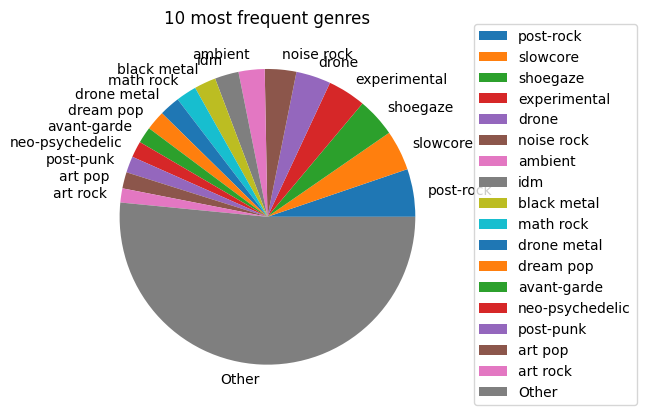

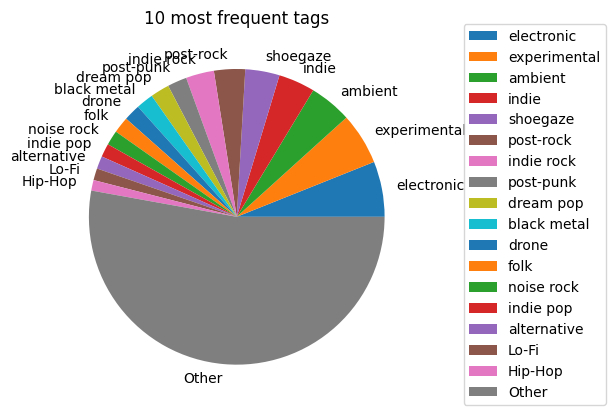

In [293]:
# show plot of 10 most frequent genres and tags
import matplotlib.pyplot as plt
import pandas as pd

# obtain list of genres and tags sorted by their occurence
limit = 17
genres = con.sql(f"""
        SELECT genre, COUNT(name) AS count 
        FROM artists INNER JOIN artist_genre ON artists.spotify_id=artist_genre.artist_id 
        GROUP BY genre ORDER BY count DESC
    """).df()
tags = con.sql(f"""
        SELECT tag, SUM(weight)/100 AS summed_weight, COUNT(name) AS count, LIST(name) AS aritists
        FROM artists INNER JOIN artist_tag ON artists.mbid=artist_tag.mbid
        GROUP BY tag ORDER BY summed_weight DESC
        """).df()
# get only the most frequent genres and tags
top_genres = genres.head(limit)
tail_genres = genres.tail(len(genres) - limit)
top_tags = tags.head(limit)
tail_tags = tags.tail(len(tags) - limit)
assert len(top_genres) + len(tail_genres) == len(genres)
assert len(top_tags) + len(tail_tags) == len(tags)
# sum all the less frequent genres and tags and add them as the last row
new_genres_row = pd.DataFrame({"genre": ["Other"], "count": [sum(tail_genres["count"])]})
new_tags_row = pd.DataFrame({"tag": ["Other"], "count": [sum(tail_tags["count"])], "summed_weight": [sum(tail_tags["summed_weight"])]})
top_genres = pd.concat([top_genres, new_genres_row], ignore_index=True)
top_tags = pd.concat([top_tags, new_tags_row], ignore_index=True)
# add labels to be visible in the pie chart, add title and legend
top_genres.index = top_genres["genre"]
top_tags.index = top_tags["tag"]
top_genres.plot(kind='pie', x='genre', y='count', xlabel="", ylabel="")
genres_title = plt.title("10 most frequent genres")
genres_legend = plt.legend(
    bbox_to_anchor=(1.1,0.5), 
    loc="center right",
    bbox_transform=plt.gcf().transFigure
    )
top_tags.plot(kind='pie', x='tag', y='summed_weight', xlabel="", ylabel="")
tags_title = plt.title("10 most frequent tags")
tags_legend=plt.legend(
    bbox_to_anchor=(1.1,0.5), 
    loc="center right",
    bbox_transform=plt.gcf().transFigure
    )

## Key Findings & Insights

Through this analysis, I discovered:
- My library contains almost 500 albums from almost 400 artists across 160 genres with more than 600 tags
- I saved most albums in year 2023, followed by 2022, 2025 and 2024
- I saved most albums at the start of the year (January, February) and the least albums during summer (June, August)
- Top genres and tags include: post-rock, slowcore, shoegaze, experimental, electronic, ambient, indie
- Using genres and tags to search similar artists give significantly different results, which could indicate that using both helped to provide more information

## Technical Takeaways
- DuckDB's `LIST()` aggregation is perfect for many-to-many relationships
- Using parameterized queries (`?` placeholders) prevents SQL injection
- Complex multi-table JOINs can answer sophisticated questions efficiently